In [39]:
%matplotlib inline
import sys
sys.path.append('../tools')
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import linear_model
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from plot_learning_curve import plot_learning_curve
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from itertools import product
from xgboost import XGBClassifier

In [2]:
sns.set_style("whitegrid", {'axes.grid' : True})

In [3]:
df = pd.read_csv('./data/train.csv', sep=',')
df_predict = pd.read_csv('./data/test.csv', sep=',')
df_out = pd.read_csv('./data/gender_submission.csv', sep=',')

In [4]:
df.head(20)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [5]:
pd.isnull(df).sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
df.shape

(891, 12)

In [7]:
df.Ticket.str.extract('([a-z|A-Z]+)', expand=False).value_counts().to_dict()

{'A': 29,
 'C': 33,
 'CA': 14,
 'F': 6,
 'Fa': 1,
 'LINE': 4,
 'P': 2,
 'PC': 60,
 'PP': 3,
 'S': 14,
 'SC': 13,
 'SCO': 1,
 'SO': 1,
 'SOTON': 17,
 'STON': 18,
 'SW': 1,
 'W': 11,
 'WE': 2}

In [8]:
#sns.heatmap(df.drop('PassengerId',axis=1).corr(), vmax=0.6, square=True, annot=True)

In [9]:
# Feature engineering

In [10]:
def fe_data(data_frame):
    
    # Title engineering
    data_frame['Title'] = data_frame.Name.str.extract(',\s([\w|\s]*)\.\s', expand=False)
    data_frame['Title'] = data_frame['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    data_frame['Title'] = data_frame['Title'].map(title_mapping)
    data_frame['Title'] = data_frame['Title'].fillna(0)
    
    # Name length
    #data_frame['Name_length'] = data_frame['Name'].apply(len)
    data_frame.drop('Name', axis=1, inplace=True)
    
    # Cabin extraction
    data_frame["Cabin"] = data_frame.Cabin.str.extract('([a-z|A-Z]+)', expand=False)
    cabin_mapping = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "T": 8}
    data_frame['Cabin'] = data_frame['Cabin'].map(cabin_mapping)
    data_frame["Cabin"].fillna(0, inplace=True)
    
    #Ticket extraction
    data_frame["Ticket"] = data_frame.Ticket.str.extract('([a-z|A-Z]+)', expand=False)
    cabin_mapping = {'A': 1, 'C': 2,'CA': 3,'F': 4,'Fa': 5,'LINE': 6, 'P': 7, 'PC': 8, 'PP': 9, 'S': 10, 'SC': 11, 'SCO': 12, 'SO': 13, 'SOTON': 14, 'STON': 15, 'SW': 16, 'W': 17, 'WE': 18}
    data_frame['Ticket'] = data_frame['Ticket'].map(cabin_mapping)
    data_frame["Ticket"].fillna(0, inplace=True)
    
    # Cabin nan?
    #data_frame["Cabin_nan"] = data_frame.Cabin.isnull()
    #data_frame.drop('Cabin', axis=1, inplace=True)
    
    # Drop ID
    data_frame.drop('PassengerId', axis=1, inplace=True)
    
    # Family size
    data_frame['Family_Size'] = data_frame['SibSp'] + data_frame['Parch'] + 1
    #data_frame['Is_Alone'] = 0
    #data_frame.loc[data_frame['Family_Size'] == 1, 'Is_Alone'] = 1
    data_frame.drop('SibSp', axis=1, inplace=True)
    data_frame.drop('Parch', axis=1, inplace=True)
    
    # Fill in missing Fare values - median
    data_frame['Fare'].fillna(data_frame['Fare'].median(), inplace=True)
    
    # Add Fare per person
    data_frame['Fare_per_person'] = data_frame['Fare'] / data_frame['Family_Size']
    
    # Mapping Fare
    data_frame.loc[ data_frame['Fare'] <= 7.91, 'Fare'] = 1
    data_frame.loc[(data_frame['Fare'] > 7.91) & (data_frame['Fare'] <= 14.454), 'Fare'] = 2
    data_frame.loc[(data_frame['Fare'] > 14.454) & (data_frame['Fare'] <= 31), 'Fare'] = 3
    data_frame.loc[ data_frame['Fare'] > 31, 'Fare'] = 4
    data_frame['Fare'] = data_frame['Fare'].astype(int)
    data_frame.drop('Fare', axis=1, inplace=True)
    
    # Modify Embarked values
    data_frame['Embarked'] = data_frame['Embarked'].fillna('S')
    #embark  = pd.get_dummies(data_frame['Embarked'], prefix="Embarked")
    #data_frame = data_frame.join(embark)
    #data_frame.drop(['S'], axis=1, inplace=True)
    
    data_frame['Embarked'] = data_frame['Embarked'].map( {'S': 1, 'C': 2, 'Q': 3} ).astype(int)
    data_frame.drop(['Embarked'], axis=1, inplace=True)
    
    # Modify Sex feature
    data_frame['Sex'] = data_frame['Sex'].map( {'female': 1, 'male': 2} ).astype(int)

    # Age intervals
    age_avg = data_frame['Age'].mean()
    age_std = data_frame['Age'].std()
    age_null_count = data_frame['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    data_frame['Age'][np.isnan(data_frame['Age'])] = age_null_random_list
    data_frame['Age'] = data_frame['Age'].astype(int)
    
    data_frame.loc[ data_frame['Age'] <= 16, 'Age'] = 0
    data_frame.loc[(data_frame['Age'] > 16) & (data_frame['Age'] <= 32), 'Age'] = 1
    data_frame.loc[(data_frame['Age'] > 32) & (data_frame['Age'] <= 48), 'Age'] = 2
    data_frame.loc[(data_frame['Age'] > 48) & (data_frame['Age'] <= 64), 'Age'] = 3
    data_frame.loc[ data_frame['Age'] > 64, 'Age']
    data_frame.drop('Age', axis=1, inplace=True)
    
    
    return data_frame

In [11]:
df = fe_data(df)

In [12]:
df.shape

(891, 8)

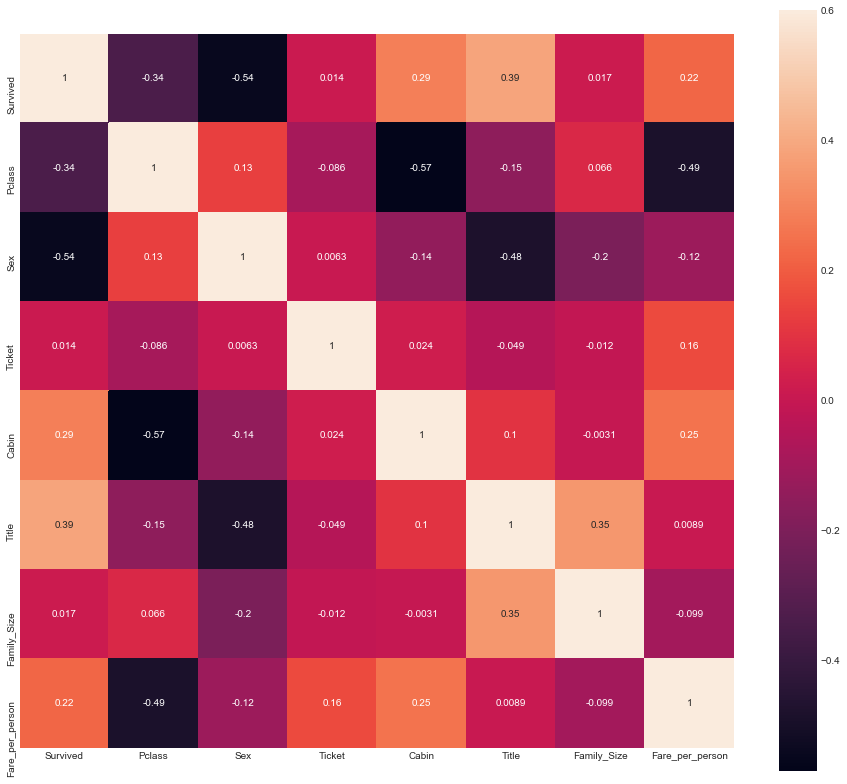

In [13]:
plt.figure(figsize=(16,14))
sns.heatmap(df.corr(), vmax=0.6, square=True, annot=True)

In [14]:
#pd_plot = pd.scatter_matrix(df,figsize=[20,20],marker='x',c=df.Survived.apply(lambda x:['red','green'][x]))

In [15]:
# Split into train and test sets

In [16]:
X = df
y = X.pop('Survived')
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [17]:
X.head(25)

,Pclass,Sex,Ticket,Cabin,Title,Family_Size,Fare_per_person
0,3,2,1.0,0.0,1.0,2,3.625000
1,1,1,8.0,3.0,3.0,2,35.641650
2,3,1,15.0,0.0,2.0,1,7.925000
3,1,1,0.0,3.0,3.0,2,26.550000
4,3,2,0.0,0.0,1.0,1,8.050000
5,3,2,0.0,0.0,1.0,1,8.458300
6,1,2,0.0,5.0,1.0,1,51.862500
7,3,2,0.0,0.0,4.0,5,4.215000
8,3,1,0.0,0.0,3.0,3,3.711100
9,2,1,0.0,0.0,3.0,2,15.035400


In [18]:
# Feature scaling

In [19]:
scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)

In [20]:
# Parameter tuning

In [21]:
#C_range = np.logspace(-2, 10, 13)
#gamma_range = np.logspace(-9, 3, 13)
#kernel = ['rbf']

#param_grid = dict(gamma=gamma_range, C=C_range, kernel=kernel)
#cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
#grid = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=cv, n_jobs=8)
#grid.fit(X_train, y_train)

#print("The best parameters are %s with a score of %0.2f" % (grid.best_params_, grid.best_score_))

In [22]:
param_grid = {"criterion": ["gini", "entropy"],
              "min_samples_split": [2, 10, 20],
              "max_depth": [None, 2, 5, 10],
              "min_samples_leaf": [1, 5, 10],
              "max_leaf_nodes": [None, 5, 10, 20],
              }

#cv = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
#grid = GridSearchCV(tree.DecisionTreeClassifier(), param_grid=param_grid, cv=cv, n_jobs=8)
#grid.fit(X_train, y_train)

#print("The best parameters are %s with a score of %0.2f" % (grid.best_params_, grid.best_score_))

In [23]:
# Classifiers

In [24]:
model_SVC_rbf = svm.SVC(kernel='rbf', C=10, gamma=0.01)
model_SVC_linear = svm.SVC(kernel='linear', C=0.2)
model_DTC = tree.DecisionTreeClassifier(criterion= 'entropy', max_depth= 5, min_samples_leaf= 5, max_leaf_nodes= 20, min_samples_split= 2)
model_RFC = RandomForestClassifier(n_estimators=100)
model_XGB = XGBClassifier()
model_ETC = ExtraTreesClassifier(n_estimators=100, max_depth=None, min_samples_split=2)
model_ABC = AdaBoostClassifier(n_estimators=100)
model_GBC = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1)
model_LOG = LogisticRegression(random_state=1)
model_GAU = GaussianNB()
model_KNN = KNeighborsClassifier(n_neighbors=7)

In [25]:
estimators=[
    ('Decision Trees', model_DTC),
    ('SVM RBF', model_SVC_rbf),
    ('SVM Linear', model_SVC_linear),
    ('Random Forest', model_RFC),
    ('Extra Trees', model_ETC),
    ('Ada Boost', model_ABC),
    ('Gradient Boosting', model_GBC),
    ('Logistic regression', model_LOG),
    ('Naive Bayes', model_GAU),
    ('KNeighbors', model_KNN),
    ('XGBoost', model_XGB)
]
eclf = VotingClassifier(estimators=estimators, voting='hard')

In [26]:
# Cross validation

In [27]:
for label, clf in estimators:
    scores = cross_val_score(clf, X_scaled, y, cv=5, scoring='accuracy')
    print("Accuracy of train set: %0.5f (+/- %0.5f) [%s]" % (scores.mean(), scores.std(), label))
scores = cross_val_score(eclf, X_scaled, y, cv=5, scoring='accuracy')
print("Accuracy of train set: %0.5f (+/- %0.5f) [%s]" % (scores.mean(), scores.std(), "Ensemble"))

Accuracy of train set: 0.82498 (+/- 0.02092) [Decision Trees]
Accuracy of train set: 0.81031 (+/- 0.01495) [SVM RBF]
Accuracy of train set: 0.78336 (+/- 0.01725) [SVM Linear]
Accuracy of train set: 0.81035 (+/- 0.02113) [Random Forest]
Accuracy of train set: 0.80700 (+/- 0.02534) [Extra Trees]
Accuracy of train set: 0.82831 (+/- 0.02925) [Ada Boost]
Accuracy of train set: 0.83395 (+/- 0.02915) [Gradient Boosting]
Accuracy of train set: 0.79685 (+/- 0.00561) [Logistic regression]
Accuracy of train set: 0.76444 (+/- 0.04253) [Naive Bayes]
Accuracy of train set: 0.80035 (+/- 0.03842) [KNeighbors]
Accuracy of train set: 0.82721 (+/- 0.02191) [XGBoost]
Accuracy of train set: 0.84069 (+/- 0.02824) [Ensemble]


In [28]:
# Feature importance

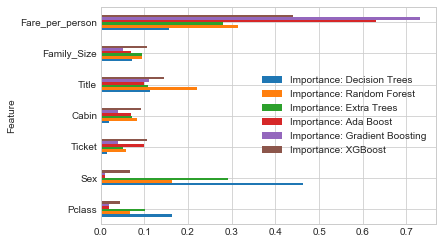

In [29]:
fi = pd.DataFrame()
fi['Feature'] = X.columns.tolist()
skip = [model_SVC_rbf, model_SVC_linear, model_LOG, model_GAU, model_KNN]
for label, clf in estimators:
    if clf not in skip:
        clf.fit(X_scaled, y)
        fi['Importance: ' + label] = clf.feature_importances_

fi.set_index(["Feature"], inplace=True)
ax = fi.plot(kind='barh')

In [30]:
# Predict and fill submit

In [31]:
df_predict.head(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S


In [32]:
pd.isnull(df_predict).sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [33]:
eclf = eclf.fit(X_scaled, y)
df_predict = fe_data(df_predict)
pd.isnull(df_predict).sum()

Pclass             0
Sex                0
Ticket             0
Cabin              0
Title              0
Family_Size        0
Fare_per_person    0
dtype: int64

In [34]:
df_predict_scaled = scaler.transform(df_predict)
df_submit = eclf.predict(df_predict_scaled)

In [35]:
df_submit

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0,

In [36]:
df_out['Survived'] = df_submit

In [37]:
df_out.head(10)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


In [38]:
df_out.to_csv('./data/out.csv', sep=',', index=False)